<a href="https://colab.research.google.com/github/Gopi138942/Deeplearning_team_collabration/blob/main/DLprj_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
class ArcFaceLoss(nn.Module):
  def __init__(self, s=30, m = 0.5, num_classes= 10, embedding_size = 512):
    super(ArcFaceLoss, self).__init__()
    self.s = s # Scaling
    self.m = m # margin
    self.w = nn.Parameter(torch.FloatTensor(num_classes, embedding_size))#define weight matrix
    nn.init.xavier_uniform_(self.w)

  def forward(self, embeddings, labels):
        norm_emb = F.normalize(embeddings)
        norm_W = F.normalize(self.w, dim=1)#access the weight matrix as self.w
        #transpose norm_W to align dimensions for matrix multiplication
        cos_theta = torch.mm(norm_emb, norm_W.t()).clamp(-1, 1)#.t() transpose the matrix from shape(10,512) to (512,10)
        target_logit = torch.acos(cos_theta[torch.arange(len(cos_theta)), labels]) + self.m
        cos_theta[torch.arange(len(cos_theta)), labels] = torch.cos(target_logit)
        return F.cross_entropy(self.s * cos_theta, labels)



In [60]:
# Unified Data Loading Function
def get_dataloader(dataset_name):
    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) if dataset_name == 'MNIST' else transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    dataset_class = datasets.MNIST if dataset_name == 'MNIST' else datasets.CIFAR10
    train_dataset = dataset_class(root='./data', train=True, download=True, transform=transform)
    test_dataset = dataset_class(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)
    return train_loader, test_loader


In [61]:
class UnifiedCNN(nn.Module):
    def __init__(self, input_channels, embedding_size=512):
        super(UnifiedCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        output_size = (28 if input_channels == 1 else 32) //2  # Handle MNIST (28x28) & CIFAR-10 (32x32)
        self.fc1 = nn.Linear(output_size * output_size * 64, embedding_size)

    def forward(self, x):
        x = self.pool(F.relu(self.conv2(F.relu(self.conv1(x))))).view(x.size(0), -1)#Dynamically calculate the size and shape
        return self.fc1(x)

In [62]:
# Training Function
def train_model(model, loss_fn, optimizer, train_loader, epochs=10):
    model.train()
    train_losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        epoch_loss = 0.0
        for images, labels in train_loader:
            # Move images and labels to the selected device
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            embeddings = model(images)
            loss = loss_fn(embeddings, labels)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        avg_epoch_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_epoch_loss)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_epoch_loss}")
    return train_losses
    print("Training finished")



In [21]:
"""def test_model(model, loss_fn, test_loader):
    model.eval()  # Set the model to evaluation mode (no gradient calculation)
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation for testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            embeddings = model(images)

            # Cosine similarity between embeddings and class weights (from the ArcFace layer)
            outputs = torch.mm(F.normalize(embeddings), F.normalize(loss_fn.w, dim=1).t())  # Cosine similarity
            _, predicted = torch.max(outputs, 1)  # Get the predicted class

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = loss_fn(embeddings, labels)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Test Loss: {avg_test_loss}")
    return avg_test_loss, accuracy"""

In [36]:
def test_model_mnist(model, loss_fn, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct, total = 0, 0

    with torch.no_grad():  # Disable gradient calculation for testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            embeddings = model(images)
            normalized_emb = F.normalize(embeddings)  # Normalize embeddings once

            # Compute cosine similarity using ArcFace class weights
            normalized_weights = F.normalize(loss_fn.w, dim=1)  # Normalize only once
            outputs = normalized_emb @ normalized_weights.t()  # Efficient matrix multiplication

            # Prediction and loss computation
            predicted = outputs.argmax(dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy


In [37]:
def test_model_cifar(model, loss_fn, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct, total, test_loss = 0, 0, 0.0

    with torch.no_grad():  # Disable gradient calculation for testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            embeddings = model(images)
            """"normalized_emb = F.normalize(embeddings)  # Normalize embeddings once

            # Compute cosine similarity using ArcFace class weights
            normalized_weights = F.normalize(loss_fn.w, dim=1)  # Normalize only once
            outputs = normalized_emb @ normalized_weights.t()  # Efficient matrix multiplication
"""
            # Prediction and loss computation
           # predicted = outputs.argmax(dim=1)

            loss = loss_fn(embeddings, labels)  # Get only the loss value
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)

    print(f"Test Loss: {avg_test_loss:.4f}")

    return avg_test_loss


In [18]:
def plot_loss(train_loss):
    plt.plot(train_loss, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

Training on MNIST:
Epoch 1/10, Loss: 1.687279932506716
Epoch 2/10, Loss: 0.6185936122548892
Epoch 3/10, Loss: 0.4602026236504798
Epoch 4/10, Loss: 0.3698880391432219
Epoch 5/10, Loss: 0.30876320234775645
Epoch 6/10, Loss: 0.26807607746185874
Epoch 7/10, Loss: 0.22851028975645038
Epoch 8/10, Loss: 0.2021674380398731
Epoch 9/10, Loss: 0.17406334909536916
Epoch 10/10, Loss: 0.15672470574439226


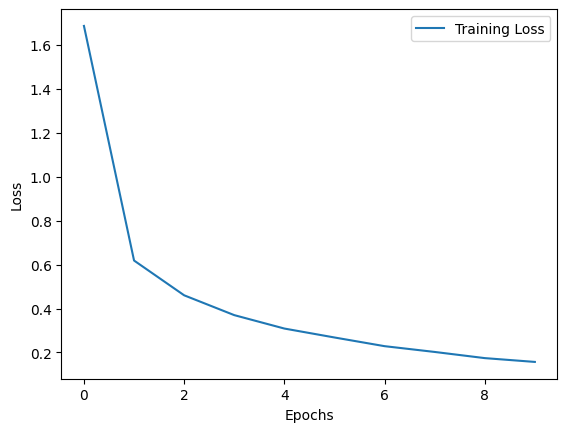

Files already downloaded and verified
Files already downloaded and verified
Training on CIFAR10:
Epoch 1/10, Loss: 13.88696843827777
Epoch 2/10, Loss: 11.732839056293068
Epoch 3/10, Loss: 10.578510669796058
Epoch 4/10, Loss: 9.73386920138698
Epoch 5/10, Loss: 8.935940649808215
Epoch 6/10, Loss: 8.25195174326982
Epoch 7/10, Loss: 7.743921978089511
Epoch 8/10, Loss: 7.307683804151043
Epoch 9/10, Loss: 6.9453962019947175
Epoch 10/10, Loss: 6.638857969237716


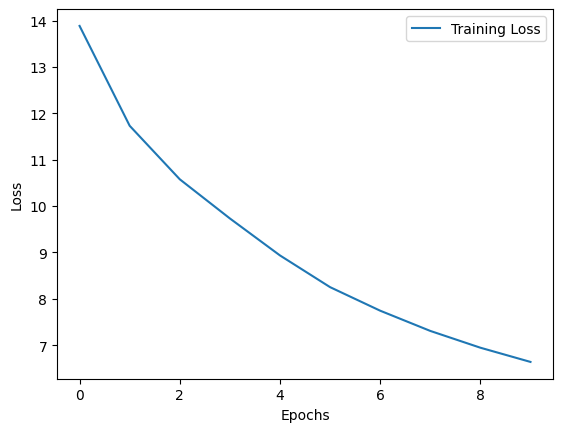

In [63]:
# Train & Test MNIST and CIFAR-10 Simultaneously
for dataset_name in ['MNIST', 'CIFAR10']:
    train_loader, test_loader = get_dataloader(dataset_name)
    model = UnifiedCNN(input_channels=1 if dataset_name == 'MNIST' else 3).to(device)
    arcface_loss = ArcFaceLoss(num_classes=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print(f"Training on {dataset_name}:")
    losses = train_model(model, arcface_loss, optimizer, train_loader)
    plot_loss(losses)



In [64]:
# Train & Test MNIST and CIFAR-10 Simultaneously
dataset_names = ['MNIST', 'CIFAR10']

for dataset_name in dataset_names:
    train_loader, test_loader = get_dataloader(dataset_name)
    model = UnifiedCNN(input_channels=1 if dataset_name == 'MNIST' else 3).to(device)
    arcface_loss = ArcFaceLoss(num_classes=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    if dataset_name == 'MNIST':
      print(f"Testing on {dataset_name}:")
      test_model_mnist(model, arcface_loss, test_loader)
    else:
      print(f"Testing on {dataset_name}:")
      test_model_cifar(model, arcface_loss, test_loader)




Testing on MNIST:
Test Accuracy: 9.79%
Files already downloaded and verified
Files already downloaded and verified
Testing on CIFAR10:
Test Loss: 17.0999
